##CBAM

In [4]:
from random import random
import numpy as np
import math
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Reshape, multiply, Permute
from tensorflow.keras.layers import Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Add, Lambda
from tensorflow.keras import backend as K
from matplotlib import pyplot
from skimage.metrics import structural_similarity
import time
from skimage import color
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

import os
import cv2

## Dataset Preparation

In [5]:
# # Load the images and masks using numpy
src_images = np.load('dataset/train_images.npy')
tar_images = np.load('dataset/train_masks.npy')
src_test_images = np.load('dataset/test_images.npy')
tar_test_images = np.load('dataset/test_masks.npy')

##Model

In [6]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev = 0.02)
    in_image = Input(shape = image_shape)

    d = Conv2D(64,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(in_image)
    d = LeakyReLU(alpha = 0.2)(d)

    d = Conv2D(128,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(d)
    d = InstanceNormalization(axis = -1)(d)
    d = LeakyReLU(alpha = 0.2)(d)

    d = Conv2D(256,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(d)
    d = InstanceNormalization(axis = -1)(d)
    d = LeakyReLU(alpha = 0.2)(d)

    d = Conv2D(512,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(d)
    d = InstanceNormalization(axis = -1)(d)
    d = LeakyReLU(alpha = 0.2)(d)

    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    model = Model(in_image, patch_out)

    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

def resnet_block(n_filters,input_layer):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])

def cbam_block(input_feature,ratio = 8):
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def res_cbam_block(n_filters,input_layer):
    init = RandomNormal(stddev = 0.02)
    g = Conv2D(n_filters,(3,3),padding = 'same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    g = cbam_block(g)
    g = Concatenate()([g,input_layer])
    return g

def channel_attention(input_feature, ratio):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(
        channel // ratio,
        activation='relu',
        kernel_initializer='he_normal',
        use_bias=True,
        bias_initializer='zeros')
    shared_layer_two = Dense(
        channel,
        kernel_initializer='he_normal',
        use_bias=True,
        bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel // ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel // ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])


def define_generator(image_shape, n_resnet=5):
    init = RandomNormal(stddev=0.02)

    in_image = Input(shape=image_shape)

    g = Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    for _ in range(3):
        # g = resnet_block(256, g)
        g = res_cbam_block(256, g)
        # g = cbam_block(g)

    g = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(1, (7, 7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('sigmoid')(g)
    #print(out_image.shape)

    model = Model(in_image, out_image)
    return model

In [13]:
model = define_generator((160,160,3), n_resnet=2)

AttributeError: Exception encountered when calling InstanceNormalization.call().

[1mCould not automatically infer the output shape / dtype of 'instance_normalization' (of type InstanceNormalization). Either the `InstanceNormalization.call()` method is incorrect, or you need to implement the `InstanceNormalization.compute_output_spec() / compute_output_shape()` method. Error encountered:

module 'keras.backend' has no attribute 'int_shape'[0m

Arguments received by InstanceNormalization.call():
  • args=('<KerasTensor shape=(None, 160, 160, 64), dtype=float32, sparse=False, name=keras_tensor_1>',)
  • kwargs=<class 'inspect._empty'>

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)  # Cast y_true_f to float32
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.cast(y_pred_f, tf.float32)  # Cast y_pred_f to float32 to ensure type consistency
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 0.00001) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
    return K.mean(focal_loss)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)

    # You can adjust the weights to balance the contributions of each loss term
    combined = 0.5 * dice + 0.5 * focal

    return combined

# Example usage in model compilation



In [ ]:
model.compile(optimizer='adam', loss=[dice_loss], metrics=[jacard_coef])

In [ ]:
history = model.fit(src_images,tar_images,batch_size = 5,epochs = 100,validation_split = 0.1)

Epoch 1/100
81/81 [==============================] - 10s 122ms/step - loss: 0.0173 - jacard_coef: 0.9660 - val_loss: 0.2206 - val_jacard_coef: 0.6411
Epoch 2/100
81/81 [==============================] - 10s 126ms/step - loss: 0.0158 - jacard_coef: 0.9689 - val_loss: 0.2200 - val_jacard_coef: 0.6420
Epoch 3/100
81/81 [==============================] - 10s 123ms/step - loss: 0.0149 - jacard_coef: 0.9707 - val_loss: 0.2205 - val_jacard_coef: 0.6414
Epoch 4/100
81/81 [==============================] - 10s 123ms/step - loss: 0.0144 - jacard_coef: 0.9717 - val_loss: 0.2189 - val_jacard_coef: 0.6433
Epoch 5/100
81/81 [==============================] - 10s 126ms/step - loss: 0.0138 - jacard_coef: 0.9729 - val_loss: 0.2200 - val_jacard_coef: 0.6419
Epoch 6/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0135 - jacard_coef: 0.9734 - val_loss: 0.2192 - val_jacard_coef: 0.6430
Epoch 7/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0131 - jacard_coef: 0.

In [ ]:
plt.plot(history.history['jacard_coef'])
plt.plot(history.history['val_jacard_coef'])
plt.title('Custom Metric')
plt.ylabel('Jacard Coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:

y_pred = (model.predict(src_test_images) )
y_pred = np.squeeze(y_pred, axis=3)

2/2 [==============================] - 0s 164ms/step


In [ ]:
jacard_coef(tar_test_images, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.63588965>

In [ ]:
dice_coef(tar_test_images,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7774237>

In [ ]:
import numpy as np

pred = (model.predict(src_test_images) * 255).astype(np.uint8)
pred = np.squeeze(pred, axis=3)


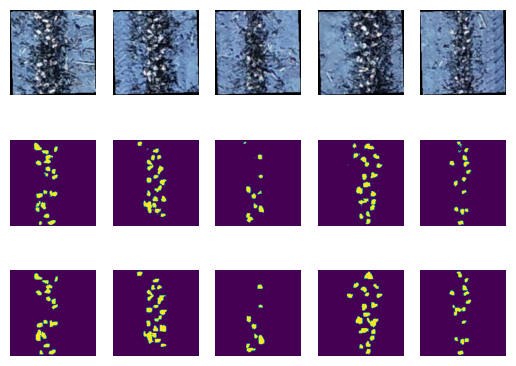

In [ ]:
n_samples = 5

# Assuming 'expected' contains your ground truth images and 'pred' contains predicted images
for i in range(n_samples):
    # Plot actual image
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_test_images[i].astype('uint8'))


    # Plot predicted image
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(pred[i].astype('uint8'))

    # Plot expected image
    plt.subplot(3, n_samples, 1 + 2 * n_samples + i)
    plt.axis('off')
    plt.imshow((tar_test_images[i]*255).astype('uint8'))

plt.show()

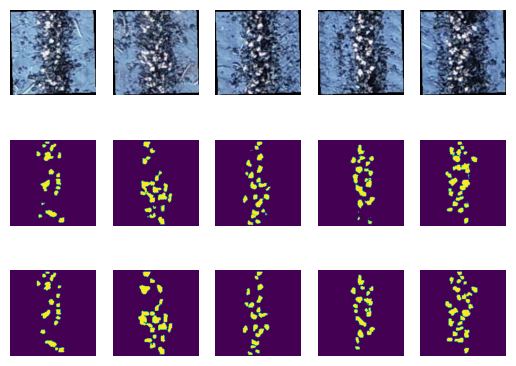

In [ ]:
n_samples = 5

# Assuming 'expected' contains your ground truth images and 'pred' contains predicted images
for i in range(n_samples):
    # Plot actual image
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_test_images[5 + i].astype('uint8'))


    # Plot predicted image
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(pred[5 + i].astype('uint8'))

    # Plot expected image
    plt.subplot(3, n_samples, 1 + 2 * n_samples + i)
    plt.axis('off')
    plt.imshow(tar_test_images[5 + i].astype('uint8'))

plt.show()